In [2]:
!pip install kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 6.0 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=7cb0d4dd50f499d22708b4f5c7d0ced7e433769e94ac41fb5e2885014fa02bf3
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle competitions download -c aptos2019-blindness-detection

100% 9.50G/9.51G [03:32<00:00, 90.4MB/s]
100% 9.51G/9.51G [03:33<00:00, 48.0MB/s]


In [7]:
! unzip aptos2019-blindness-detection.zip
# ! unzip train_images.zip
# ! unzip test_images.zip

Streaming output truncated to the last 5000 lines.
  inflating: test_images/51323e9d2070.png  
  inflating: test_images/515675001b9e.png  
  inflating: test_images/515877da2def.png  
  inflating: test_images/5168ddccea88.png  
  inflating: test_images/5172c056a687.png  
  inflating: test_images/5177461f5339.png  
  inflating: test_images/51910bcb980d.png  
  inflating: test_images/51a3e9b6a1c0.png  
  inflating: test_images/51bbd82feec8.png  
  inflating: test_images/51de5fb8eccd.png  
  inflating: test_images/51e88694c81f.png  
  inflating: test_images/51f0bf8f1544.png  
  inflating: test_images/51f57fb32840.png  
  inflating: test_images/51fa42dc1415.png  
  inflating: test_images/5276ab33b7b0.png  
  inflating: test_images/52a353760f72.png  
  inflating: test_images/531937254e73.png  
  inflating: test_images/5325b1c22c61.png  
  inflating: test_images/53959e0a750b.png  
  inflating: test_images/53be22c72713.png  
  inflating: test_images/5400549bfe76.png  
  inflating: test_images/

In [8]:
import cv2
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import PIL.Image as Image

from sklearn.utils import class_weight, shuffle
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader

from torchvision import models,transforms
from tqdm import trange

# Set random seed for reproducibility
seed = 1234
# cuDNN uses nondeterministic algorithms, set some options for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)

%matplotlib inline
# Use GPU if it's available or else use CPU.
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

IMG_SIZE = 512

import warnings
warnings.filterwarnings("ignore")

cpu


In [9]:
train_data = pd.read_csv('/content/train.csv')
print("No.of.training_samples:",len(train_data))
train_data.head()

No.of.training_samples: 3662


id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

# Pre-processing

(3112,) (3112,) (550,) (550,)


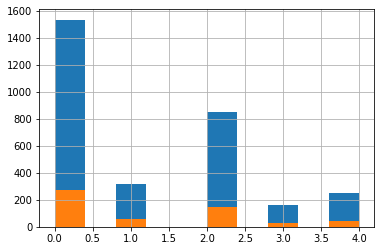

In [10]:
x = train_data['id_code']
y = train_data['diagnosis']

x, y = shuffle(x, y, random_state=seed)

train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.15,
                                                      stratify=y, random_state=seed)
print(train_x.shape, train_y.shape, valid_x.shape, valid_y.shape)
train_y.hist()
valid_y.hist()

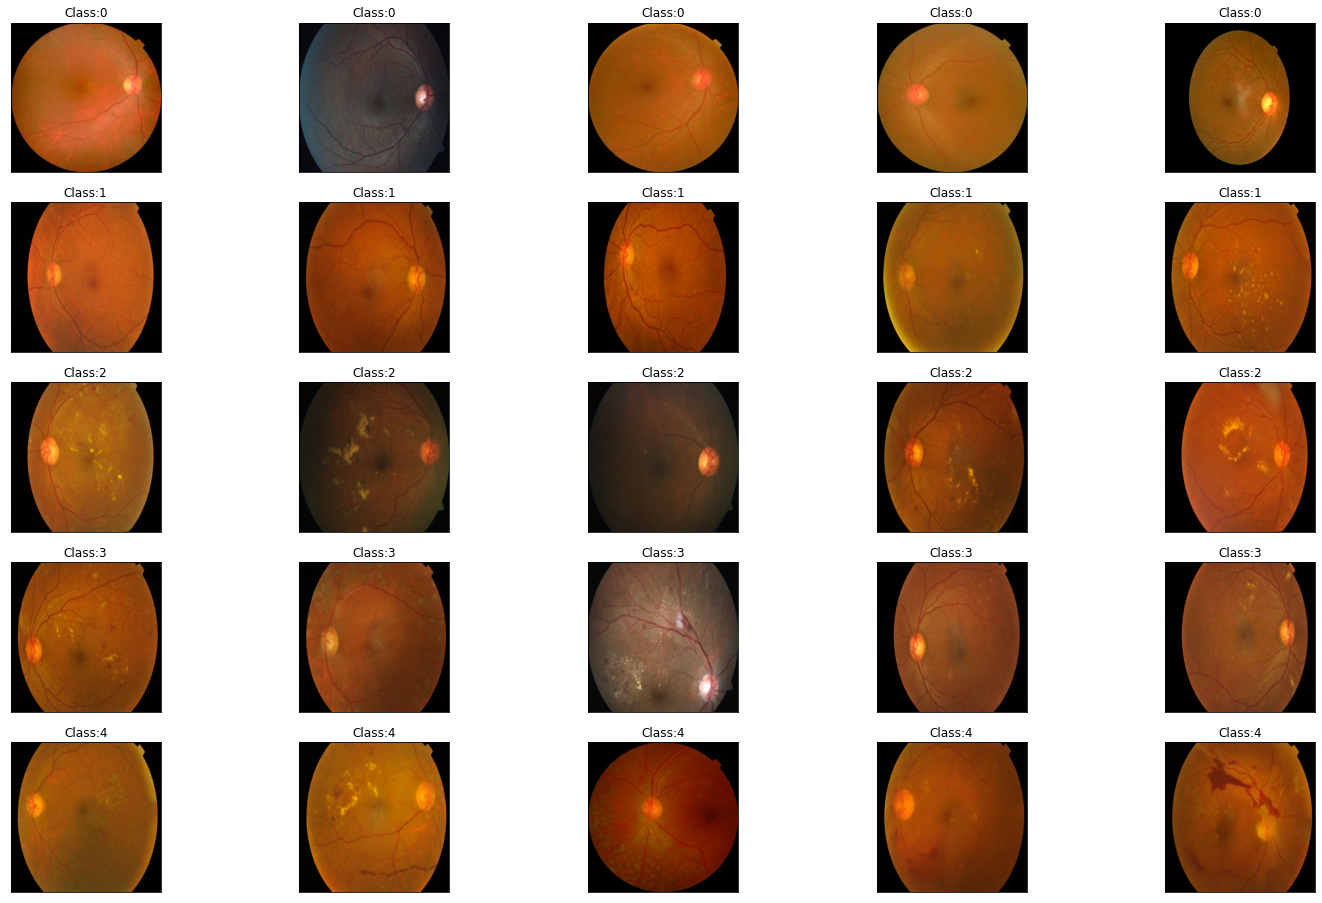

In [11]:
fig = plt.figure(figsize=(25, 16))
# Display 5 images from each class
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(train_data.loc[train_data['diagnosis'] == class_id].sample(5, random_state=seed).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"/content/train_images/{row['id_code']}.png"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        plt.imshow(image)
        ax.set_title('Class:'+str(class_id))

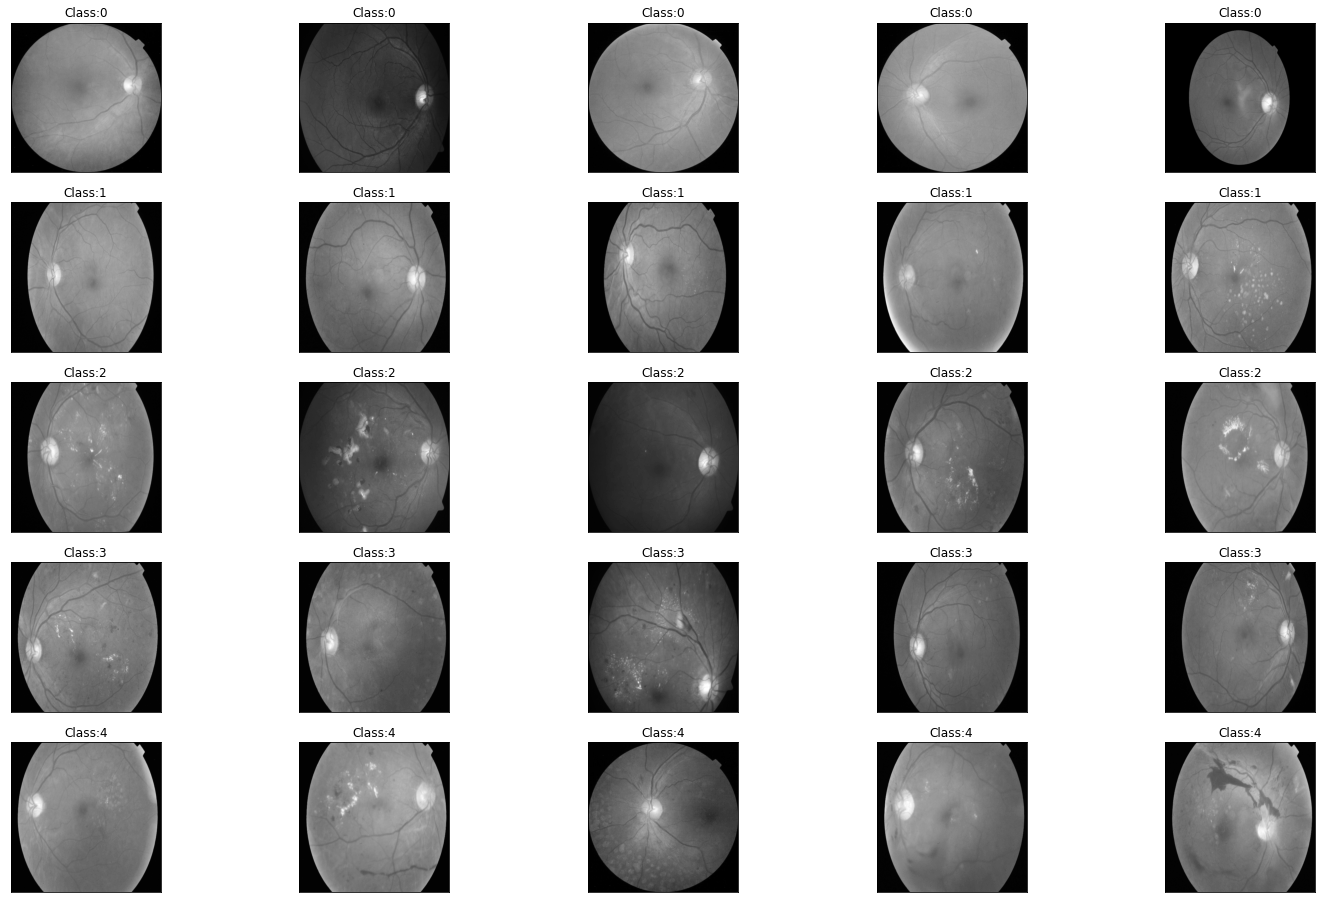

In [12]:
#Grayscaling the images
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(train_data.loc[train_data['diagnosis'] == class_id].sample(5, random_state=seed).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"/content/train_images/{row['id_code']}.png"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        plt.imshow(image, cmap='gray')
        ax.set_title('Class:'+str(class_id))

To improve lighting condition

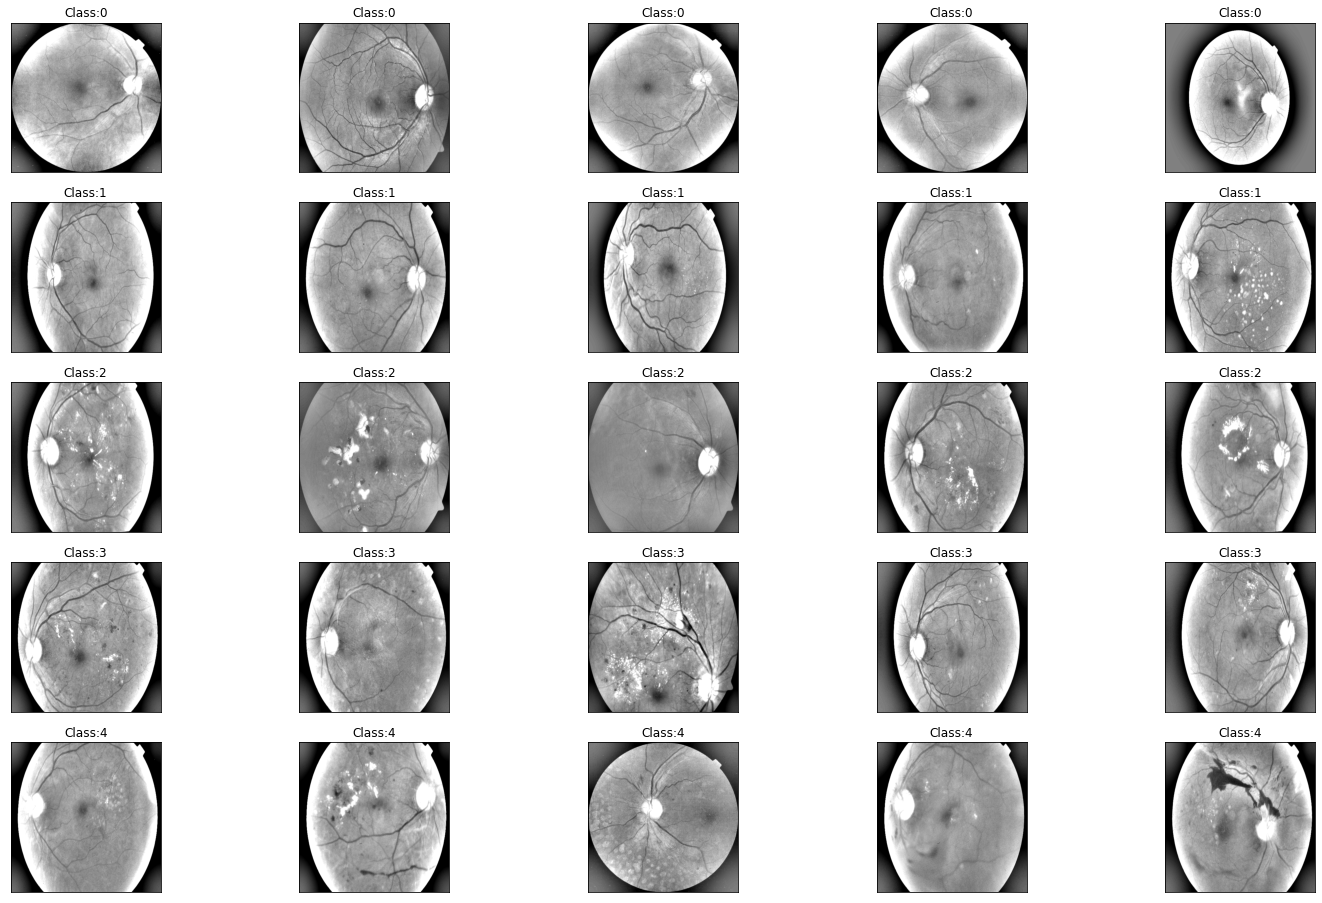

In [14]:
# To improve lighting conditon
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(train_data.loc[train_data['diagnosis'] == class_id].sample(5, random_state=seed).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"/content/train_images/{row['id_code']}.png"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        image=cv2.addWeighted( image,4, cv2.GaussianBlur( image , (0,0) , IMG_SIZE/10) ,-4 ,128)
        plt.imshow(image, cmap='gray')
        ax.set_title('Class:'+str(class_id))

Auto Cropping

In [15]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

In [16]:
def load_trans_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
    return image

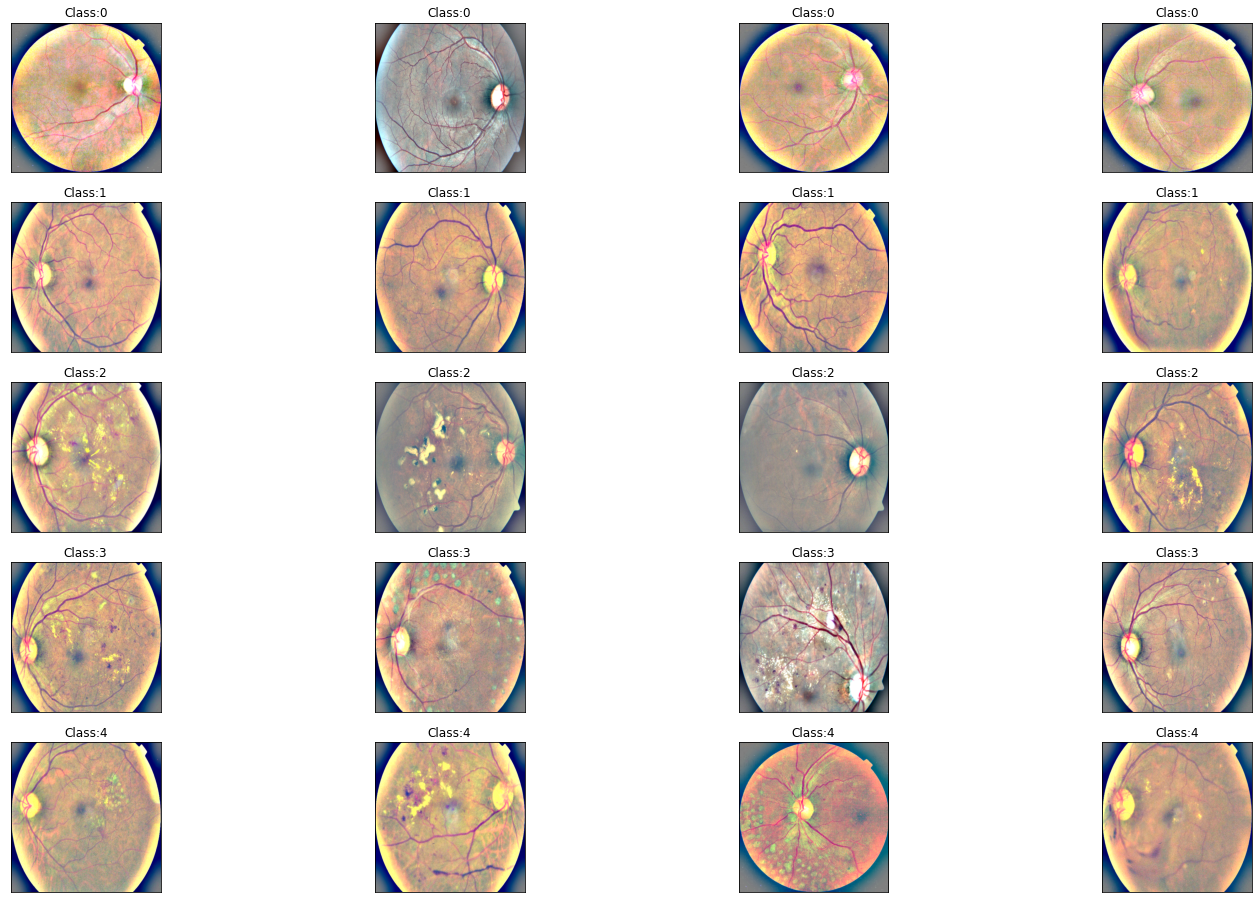

In [17]:
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(train_data.loc[train_data['diagnosis'] == class_id].sample(4, random_state=seed).iterrows()):
        ax = fig.add_subplot(5, 4, class_id * 4 + i + 1, xticks=[], yticks=[])
        path=f"/content/train_images/{row['id_code']}.png"
        image = load_trans_color(path,sigmaX=30)
        plt.imshow(image)
        ax.set_title('Class:'+str(class_id))

Circle Crop

In [18]:
def circle_crop(img, sigmaX=10):   
    """
    Create circular crop around image centre    
    """    
    
    img = cv2.imread(img)
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

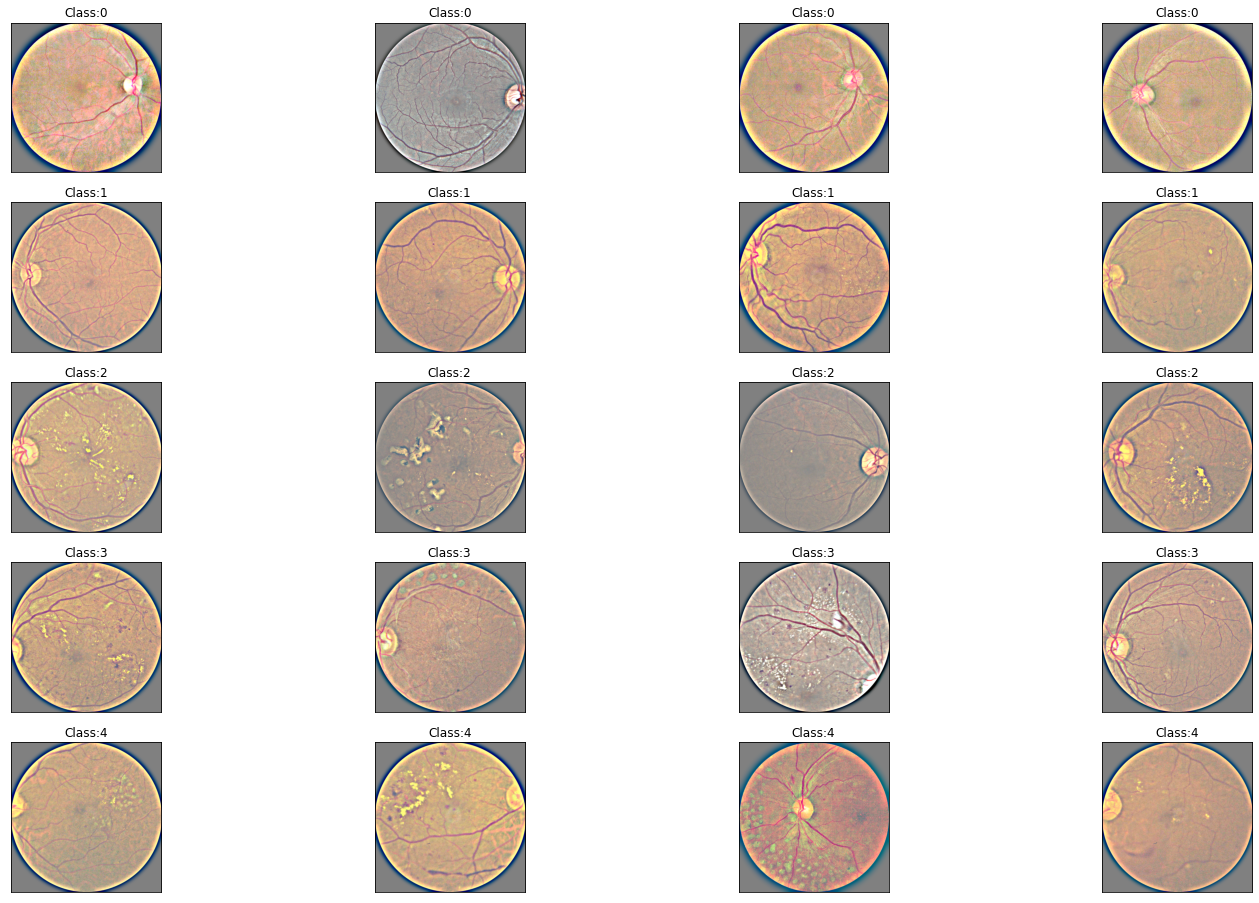

In [19]:
# Circle crop
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(train_data.loc[train_data['diagnosis'] == class_id].sample(4, random_state=seed).iterrows()):
        ax = fig.add_subplot(5, 4, class_id * 4 + i + 1, xticks=[], yticks=[])
        path=f"/content/train_images/{row['id_code']}.png"
        image = circle_crop(path,sigmaX=30)
        plt.imshow(image)
        ax.set_title('Class:'+str(class_id))

Now that these images are run through Gaussian Blurring, we get clear images and can classify with higher accuracy since the most important features are highlighted.

# CNN

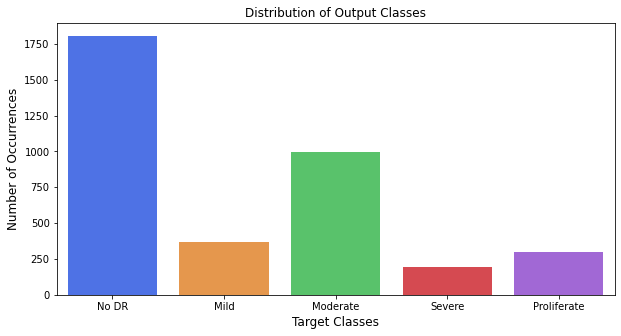

In [21]:
# Distribution of classes.
counts = train_data.diagnosis.value_counts()
class_list = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferate']
for i,x in enumerate(class_list):
    counts[x] = counts.pop(i)

plt.figure(figsize=(10,5))
sns.barplot(x=counts.index, y=counts.values, alpha=0.8, palette='bright')
plt.title('Distribution of Output Classes')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Target Classes', fontsize=12)
plt.show()

The data is imbalanced: 49% images are from healthy patients. The remaining 51% are different stages of DR. The least common class is 3 (severe stage) with only 5% of the total examples.

The data is collected from multiple clinics using a variety of camera models, which creates discrepancies in the image resolution, aspect ratio and other parameters. This is demonstrated in the snippet below, where we plot histograms of image width, height and aspect ratio.

In [22]:
#As the data is imbalanced, we've to calculate weights for each class, which can be used in calculating loss.

#For calculating weights for each class.
from sklearn.utils import class_weight 
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.array([0,1,2,3,4]), y=train_data['diagnosis'].values)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)

# Print the calculated weights for the classes.
print(class_weights) 

tensor([0.4058, 1.9795, 0.7331, 3.7948, 2.4827])


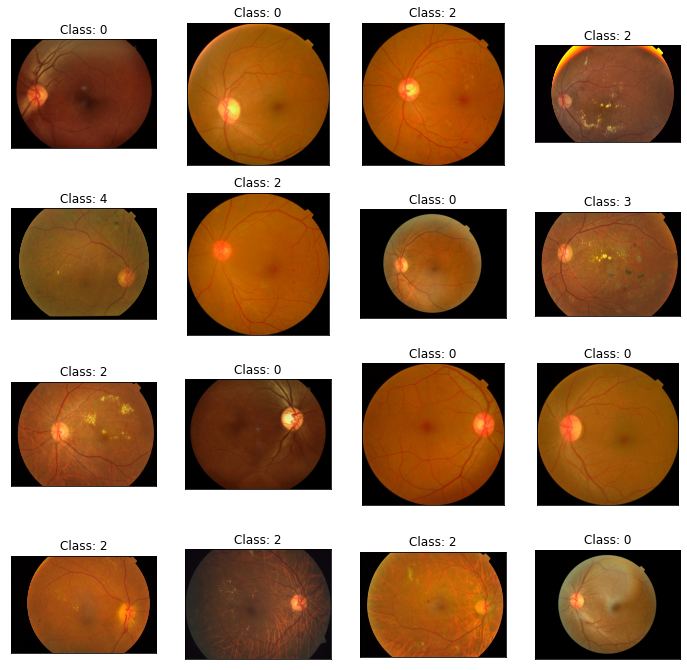

In [23]:
import os

fig = plt.figure(figsize=(12, 12))
# display random 16 images
train_imgs = os.listdir("/content/train_images/")
for idx, img in enumerate(np.random.choice(train_imgs, 16)):
    ax = fig.add_subplot(4, 4, idx+1, xticks=[], yticks=[])
    im = Image.open('/content/train_images/' + img)
    plt.imshow(im)
    lab = train_data.loc[train_data['id_code'] == img.split('.')[0], 'diagnosis'].values[0]
    ax.set_title('Class: %s'%lab)

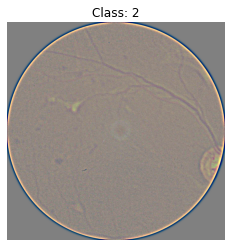

In [24]:
# For getting a random image from our training set after circle crop or lighting improvement.
num = int(np.random.randint(0,len(train_data)-1,(1,)))
sample_image = '/content/train_images/'+ train_data["id_code"][num] + '.png'
# cv_image = circle_crop(sample_image, sigmaX=10)
cv_image = load_trans_color(sample_image, sigmaX=10)
sample_image = Image.fromarray(cv_image)

plt.imshow(sample_image)
plt.axis('off')
plt.title(f'Class: {train_data["diagnosis"][num]}')
plt.show()

In [25]:
# Inherits from the Dataset class.
class dataset(Dataset): 
    '''
    dataset class overloads the __init__, __len__, __getitem__ methods of the Dataset class. 
    
    Attributes :
        df:  DataFrame object for the csv file.
        data_path: Location of the dataset.
        image_transform: Transformations to apply to the image.
        train: A boolean indicating whether it is a training_set or not.
    '''
    
    def __init__(self,df,data_path,image_transform=None,train=True):
        super(Dataset,self).__init__()
        self.df = df
        self.data_path = data_path
        self.image_transform = image_transform
        self.train = train
        
    def __len__(self):
        # Returns the number of samples in the dataset.
        return len(self.df) 
    
    def __getitem__(self, index):
        image_id = self.df['id_code'][index]
        image = Image.open(f'{self.data_path}/{image_id}.png')
        # If applying pre-processing
        cv_image = load_trans_color(f'{self.data_path}/{image_id}.png', sigmaX=10)
        # Converting the cv image
        image = Image.fromarray(cv_image)
  
        # Apply transformation to the image.
        if self.image_transform :
            image = self.image_transform(image) 
        
        if self.train :
            label = self.df['diagnosis'][index]
            return image, label 
        else:
            return image
          

In [26]:
# Initial transform (convert to PyTorch Tensor only)
# transform = transforms.Compose([
#     transforms.ToTensor(),
# ])

## Use the following lines to check the basic statistics of this dataset
# Calculate training data mean and standard deviation to apply normalization to data
# train_data.data are of type uint8 (range 0,255) so divide by 255.
# train_mean = train_data.data.double().mean() / 255.
# train_std = train_data.data.double().std() / 255.
# print(f'Train Data: Mean={train_mean}, Std={train_std}')

## Optional: Perform normalization of train and test data using calculated training mean and standard deviation
# This will convert data to be approximately standard normal
# transform = transforms.Compose([
#    transforms.ToTensor(),
#    transforms.Normalize((train_mean, ), (train_std, ))
# ])

transform = transforms.Compose([transforms.Resize([64,64]),
                                      transforms.ToTensor(),
                                      transforms.RandomRotation((-360, 360)),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.RandomVerticalFlip(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) #Transformations to apply to the image.

# #test transformations
# transform = transforms.Compose([transforms.Resize([512,512]), 
#                                 transforms.ToTensor(), 
#                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) 

data_set = dataset(train_data, '/content/train_images', image_transform=transform)

train_len = int(0.8*len(data_set))
test_len = len(data_set) - train_len
print(len(data_set), train_len, test_len)

# Split the data_set so that valid_set contains 0.2 samples of the data_set. 
train_data, test_data = torch.utils.data.random_split(data_set, [train_len, test_len])

print(len(train_data), len(test_data))

batch_size = 32
torch.manual_seed(seed)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=True) 
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=True) 

3662 2929 733
2929 733


Images shape:  torch.Size([32, 3, 64, 64])
Labels shape:  torch.Size([32])
Mean=0.14750562608242035, Std=0.8247658610343933


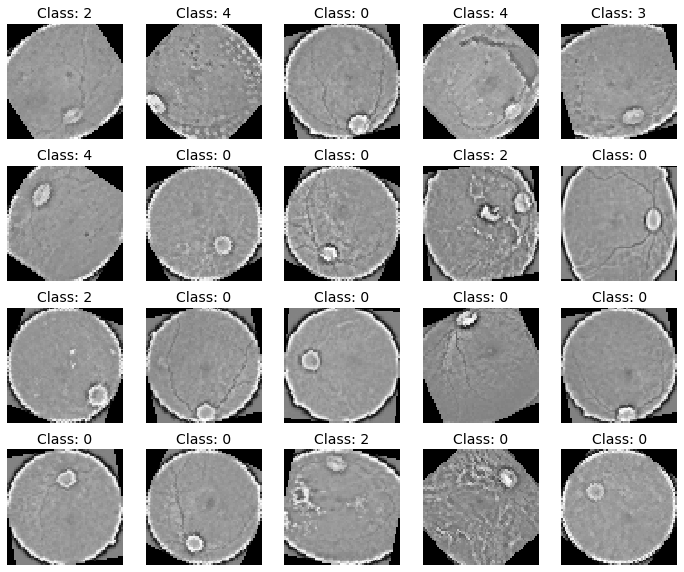

In [27]:
# Randomly sample 20 images of the training dataset
images, labels = iter(train_loader).next()

# Print information and statistics of the first batch of images
print("Images shape: ", images.shape)
print("Labels shape: ", labels.shape)
print(f'Mean={images.mean()}, Std={images.std()}')

fig = plt.figure(figsize=(12, 10))
for i in np.arange(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(images[i][0].squeeze(), cmap='gray', interpolation='none')
    plt.title(f'Class: {labels[i]}', fontsize=14)
    plt.axis('off')

In [28]:
class Net(nn.Module):
    def __init__ (self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.pool = nn.MaxPool2d(2, 2) 
        self.conv2 = nn.Conv2d(8, 8, 5)
        self.conv3 = nn.Conv2d(8, 16, 5)

        self.fc1 = nn.Linear(256, 2000)
        self.fc2 = nn.Linear(2000, 120)
        self.fc3 = nn.Linear(120, 80)
        self.fc4 = nn.Linear(80, 5)
        # Generalizes outputs
        self.dropout = nn.Dropout(0.2) 

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x) 

        # print(x.shape)
        x = x.view(-1, 16*4*4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x
    
model = Net().to(DEVICE)
# sanity check
print(model)
from torchsummary import summary
summary(model, (3, 64, 64))

Net(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=2000, bias=True)
  (fc2): Linear(in_features=2000, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=80, bias=True)
  (fc4): Linear(in_features=80, out_features=5, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 60, 60]             608
         MaxPool2d-2            [-1, 8, 30, 30]               0
            Conv2d-3            [-1, 8, 26, 26]           1,608
         MaxPool2d-4            [-1, 8, 13, 13]               0
            Conv2d-5             [-1, 16, 9, 9]         

In [35]:
def train_one_epoch(train_loader, model, device, optimizer, log_interval, epoch):
    model.train()
    losses = []
    counter = []

    total = 0
    num_correct = 0
    running_loss = 0
    
    for i, (img, label) in enumerate(train_loader):
        img, label = img.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss(output, label)
        running_loss += loss.item()

        total+= label.size(0)
        pred = output.max(1, keepdim = True)[1]
        num_correct += pred.eq(label.view_as(pred)).sum().item()

        loss.backward()
        optimizer.step()
    
        # Record training loss every log_interval and keep counter of total training images seen
        if (i+1) % log_interval == 0:
            losses.append(loss.item())
            counter.append(
                (i * batch_size) + img.size(0) + epoch * len(train_loader.dataset))
    
    avg_loss = running_loss/len(train_loader)
    train_accuracy = 100*(num_correct/total)
    print(f'\nTraining Loss = {avg_loss:.6f}',end='\t')
    print(f'Accuracy on Training set = {100*(num_correct/total):.6f}% [{num_correct}/{total}]') #Prints the Accuracy.

    return avg_loss, num_correct, train_accuracy

In [36]:
def test_one_epoch(test_loader, model, device):
    model.eval()
    test_loss = 0
    num_correct = 0
    total = 0
    
    with torch.no_grad():
        for i, (img, label) in enumerate(test_loader):
            img, label = img.to(device), label.to(device)
            output = model(img)
            pred = output.max(1, keepdim = True)[1]
            num_correct += pred.eq(label.view_as(pred)).sum().item()

            loss = nn.CrossEntropyLoss(weight=class_weights)
            test_loss += loss(output, label).item()
            total += label.size(0)
            
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100*(num_correct/total)
    print(f'\nTest Loss = {test_loss:.6f}',end='\t')
    print(f'Accuracy on Test set = {100*(num_correct/total):.6f}% [{num_correct}/{total}]')
    return test_loss, num_correct, test_accuracy

In [ ]:
# Hyperparameters
lr = 0.01
max_epochs=10
gamma = 0.95

# Recording data
log_interval = 100

# Instantiate optimizer (model was created in previous cell)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

train_losses = []
train_counter = []
test_losses = []
test_correct = []
train_accuracy, test_accuracy = [], []

for epoch in trange(max_epochs, leave=True, desc='Epochs'):
    print(f'\nEpoch {epoch+1}/{max_epochs}')
    print('-------------------------------')
    train_loss, counter, train_acc = train_one_epoch(train_loader, model, DEVICE, optimizer, log_interval, epoch)
    test_loss, num_correct, test_acc = test_one_epoch(test_loader, model, DEVICE)

    # Record results
    train_losses.append(train_loss)
    train_counter.append(counter)
    test_losses.append(test_loss)
    test_correct.append(num_correct)
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)
    print(train_losses, test_losses, train_accuracy, test_accuracy)

print('\nTraining has completed!')

print(f"Test accuracy: {test_correct[-1]/len(test_loader.dataset)}")
print(f"Train accuracy: {train_correct[-1]/len(train_loader.dataset)}")

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 1/10
-------------------------------

Training Loss = 1.609760	Accuracy on Training set = 47.900307% [1403/2929]


Epochs:  10%|█         | 1/10 [13:08<1:58:18, 788.71s/it]


Test Loss = 0.050561	Accuracy on Test set = 49.658936% [364/733]
[1.6097596728283425] [0.050560862110549075] [47.900307272106524] [49.65893587994543]

Epoch 2/10
-------------------------------

Training Loss = 1.609493	Accuracy on Training set = 46.466371% [1361/2929]


Epochs:  20%|██        | 2/10 [26:17<1:45:11, 788.98s/it]


Test Loss = 0.050544	Accuracy on Test set = 49.658936% [364/733]
[1.6097596728283425, 1.6094925092614216] [0.050560862110549075, 0.0505439963542423] [47.900307272106524, 46.466370775008535] [49.65893587994543, 49.65893587994543]

Epoch 3/10
-------------------------------


In [ ]:
print(train_losses, test_losses)

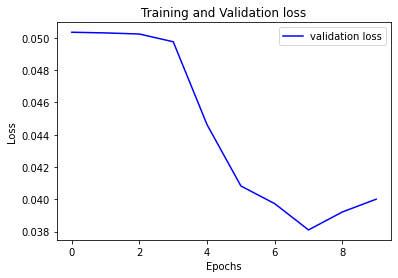

In [ ]:
# Plot the graph of train_losses & valid_losses against nb_epochs.
epochs = range(max_epochs)
# plt.plot(epochs, train_losses, 'g', label='Training loss')
plt.plot(epochs, test_losses, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

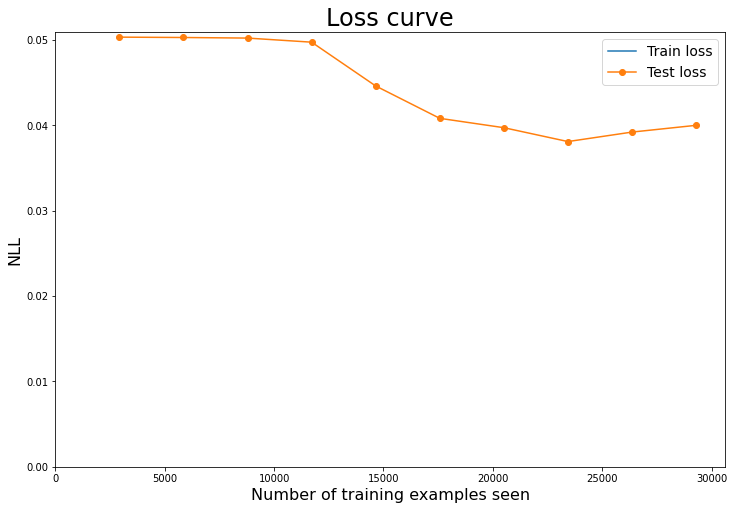

In [ ]:
# Draw training loss curve
fig = plt.figure(figsize=(12,8))
plt.plot(train_counter, train_losses, label='Train loss')
plt.plot([i * len(train_loader.dataset) for i in range(1, max_epochs + 1)], 
         test_losses, label='Test loss', marker='o')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.title('Loss curve', fontsize=24)
plt.xlabel('Number of training examples seen', fontsize=16)
plt.ylabel('NLL', fontsize=16)
plt.legend(loc='upper right', fontsize=14)

In [ ]:
model.eval()
results = []
i = 0
j = 0
k = 0
l = 0
m = 0
for x, y in DataLoader(data_set):
  if (y.numpy()[0] == 0 and i<=20):
    result = model(x.to(DEVICE)).argmax(dim=1).cpu().detach()
    results.append((result.numpy()[0], y.numpy()[0]))
    i = i+1
  if (y.numpy()[0] == 1 and j<=20):
    result = model(x.to(DEVICE)).argmax(dim=1).cpu().detach()
    results.append((result.numpy()[0], y.numpy()[0]))
    j = j+1
  if (y.numpy()[0] == 2 and k<=20):
    result = model(x.to(DEVICE)).argmax(dim=1).cpu().detach()
    results.append((result.numpy()[0], y.numpy()[0]))
    k = k+1
  if (y.numpy()[0] == 3 and l<=20):
    result = model(x.to(DEVICE)).argmax(dim=1).cpu().detach()
    results.append((result.numpy()[0], y.numpy()[0]))
    l = l+1
  if (y.numpy()[0] == 4 and m<=20):
    result = model(x.to(DEVICE)).argmax(dim=1).cpu().detach()
    results.append((result.numpy()[0], y.numpy()[0]))
    m = m+1
  if(i+j+k+l+m >=100):
    break

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

labels = [val[1] for val in results]
preds = [val[0] for val in results]

cm = confusion_matrix(labels, preds, labels=[0, 1, 2, 3, 4])
cm

array([[17,  0,  0,  4,  0],
       [ 0, 12,  0,  9,  0],
       [ 2,  3,  0, 16,  0],
       [ 0,  7,  0,  9,  0],
       [ 0,  2,  0, 19,  0]])

In [ ]:
cm_df = pd.DataFrame(cm,
                     index = ['0','1','2', '3', '4'], 
                     columns = ['0','1','2', '3', '4'])
cm_df

0   1  2   3  4
0  17   0  0   4  0
1   0  12  0   9  0
2   2   3  0  16  0
3   0   7  0   9  0
4   0   2  0  19  0

In [ ]:
total = sum(cm_df.sum(axis=1))

In [ ]:
arr = np.array(cm_df)
cnfm = []
for i in range(0,5):
  TP = arr[:][i][i]
  FN = sum(arr[:][i]) - arr[:][i][i]
  FP = cm_df.sum(axis=0)[i] - arr[:][i][i]
  TN = total - TP
  precision = TP /(TP+FP)
  recall  = TP/(TP+FN)
  f1 = 2*precision*recall/(precision+recall)
  cnfm.append([i, TP,FN,FP,TN, precision, recall, f1])
f1_result = pd.DataFrame(cnfm, columns = ['severity', 'True Positive','False Negative','False Positive', 'True Negative', 'Precision', 'Recall', 'F1-score'])
f1_result

severity  True Positive  False Negative  ...  Precision    Recall  F1-score
0         0             17               4  ...   0.894737  0.809524  0.850000
1         1             12               9  ...   0.500000  0.571429  0.533333
2         2              0              21  ...        NaN  0.000000       NaN
3         3              9               7  ...   0.157895  0.562500  0.246575
4         4              0              21  ...        NaN  0.000000       NaN

[5 rows x 8 columns]

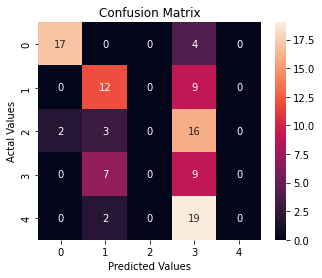

In [ ]:
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, auc

def test_class_probabilities(model, test_loader):
    model.eval()
    actuals = []
    probabilities = []
    i = 0
    j = 0
    k = 0
    l = 0
    f = 0
    with torch.no_grad():
        for x, y in test_loader:
          y = y.numpy()[0]
          outputs = model(x.to(device))
          prediction = outputs.argmax(dim=1, keepdim=True).cpu().detach()
          # if (prediction.numpy()[0] == y):
          if (y == 0 and i<10):
            actuals.append(y)
            values = outputs.cpu().detach().numpy()[0]
            m = -1*min(values)
            values = [val+m for val in values]
            prob = values/sum(values)
            probabilities.append(np.exp(prob))
            i = i+1
          if (y == 1 and j<10):
            actuals.append(y)
            values = outputs.cpu().detach().numpy()[0]
            m = -1*min(values)
            values = [val+m for val in values]
            prob = values/sum(values)
            probabilities.append(np.exp(prob))
            j = j+1
          if (y == 2 and k<10):
            actuals.append(y)
            values = outputs.cpu().detach().numpy()[0]
            m = -1*min(values)
            values = [val+m for val in values]
            prob = values/sum(values)
            probabilities.append(np.exp(prob))
            k = k+1
          if (y == 3 and l<10):
            actuals.append(y)
            values = outputs.cpu().detach().numpy()[0]
            m = -1*min(values)
            values = [val+m for val in values]
            prob = values/sum(values)
            probabilities.append(np.exp(prob))
            l = l+1
          if (y == 4 and f<10):
            actuals.append(y)
            values = outputs.cpu().detach().numpy()[0]
            m = -1*min(values)
            values = [val+m for val in values]
            prob = values/sum(values)
            probabilities.append(np.exp(prob))
            f = f+1
          if(i+j+k+l+f >=50):
            break
    return actuals,probabilities


def plot_roc( actuals,  probabilities):
    """
    compute ROC curve and ROC area for each class in each fold

    """
    fpr = {}
    tpr = {}
    thresh ={}
    roc_auc = {}
    n_class = 5

    for i in range(n_class):    
        fpr[i], tpr[i], thresh[i] = roc_curve(actuals, [val[i] for val in probabilities], pos_label=i)
        roc_auc[i] = auc(fpr[i], tpr[i])

        
    # plotting    
    plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label="Class 0 vs Rest (area = %0.2f)" % roc_auc[0])
    plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label="Class 1 vs Rest (area = %0.2f)" % roc_auc[1])
    plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label="Class 2 vs Rest (area = %0.2f)" % roc_auc[2])
    plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label="Class 3 vs Rest (area = %0.2f)" % roc_auc[3])
    plt.plot(fpr[3], tpr[3], linestyle='--',color='purple', label="Class 4 vs Rest (area = %0.2f)" % roc_auc[4])
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.title('Multiclass ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')

In [ ]:
act, prob = test_class_probabilities(model, DataLoader(data_set))

In [ ]:
plot_roc(act, prob)
print(act)